##  **Customer Churn Prediction — Machine Learning Model Development**

This notebook builds the machine learning pipeline for predicting customer churn using the IBM Telco Customer Churn dataset.  
It follows the second phase of the project, after exploratory data analysis (EDA) has already identified key churn patterns and hypotheses.

##  **Project Objective**
To develop an interpretable, high-performance churn prediction model that:
- Accurately identifies customers at high risk of churn  
- Handles class imbalance effectively  
- Provides explainable insights using SHAP  
- Supports business decision-making with actionable predictions  

##  **What This Notebook Covers**
- Data preprocessing (encoding + scaling)  
- Feature engineering (AvgCharges, TenureGroup, TechSupportBundle)  
- Statistical validation (T-tests, Chi-square tests)  
- Model training (Logistic Regression, Random Forest, Gradient Boosting, etc.)  
- Imbalance handling using SMOTE  
- Threshold tuning for optimal recall/F1  
- SHAP explainability  
- Saving final model + prediction function for deployment  

##  **Input**
- Cleaned dataset from EDA phase (`customer_churn_cleaned.csv`)

##  **Output**
- Final tuned churn model  
- Preprocessing pipeline  
- SHAP interpretability plots  
- Deployment-ready `predict_churn()` function  


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
df = pd.read_csv("customer_churn_cleaned.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup
0,7590-VHVEG,Female,no,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-15
1,5575-GNVDE,Male,no,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,16-30
2,3668-QPYBK,Male,no,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-15
3,7795-CFOCW,Male,no,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,16-30
4,9237-HQITU,Female,no,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-15


In [96]:
# Identifying numerical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# identifying categorical columns 
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

numeric_cols, categorical_cols


(['tenure', 'MonthlyCharges', 'TotalCharges'],
 ['customerID',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn',
  'TenureGroup'])

In [97]:
categorical_cols.remove('customerID')

In [98]:
#encoding target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [100]:
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [101]:
#seperating features(X) and target (Y)
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

X.shape, y.shape

((7043, 20), (7043,))

In [102]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_cols, categorical_cols


(['tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'TenureGroup'])

## **t-test for MonthlyCharges**

In [103]:
from scipy.stats import ttest_ind

In [104]:
churn_yes = df[df['Churn'] == 1]['MonthlyCharges']
churn_no = df[df['Churn'] == 0]['MonthlyCharges']

t_stat, p_value = ttest_ind(churn_yes, churn_no)

t_stat, p_value


(np.float64(16.536738015936308), np.float64(2.7066456068884154e-60))

 **Null Hypothesis (H₀)**
There is no difference in average **MonthlyCharges** between customers who churn and those who stay.

 **Alternative Hypothesis (H₁)**
There is a significant difference in average **MonthlyCharges** between the two groups.

**Test Results**
- **t-statistic:** 16.54  
- **p-value:** 2.70 × 10⁻⁶⁰  

The p-value is extremely close to zero and far below the **0.05** significance level.  
**Therefore, we reject the null hypothesis.**

**Conclusion:**  
The difference in **MonthlyCharges** between churned and non-churned customers is **statistically significant**.

**Business Impact**
- Conduct **pricing sensitivity analysis** for high-charge customers.  
- Offer **targeted discounts**, **loyalty benefits**, or **plan optimizations** to reduce churn.  
- Flag high-charge customers as **high churn risk** in ML models and retention strategies.


## **Chi-Square Test**

In [ ]:
from scipy.stats import chi2_contingency

tests = {
    "Contract vs Churn": pd.crosstab(df['Contract'], df['Churn']),
    "TenureGroup vs Churn": pd.crosstab(df['TenureGroup'], df['Churn']),
    "InternetService vs Churn": pd.crosstab(df['InternetService'], df['Churn'])
}

chi_results = {}

for name, table in tests.items():
    chi2, p, dof, expected = chi2_contingency(table)
    chi_results[name] = {
        "chi2": chi2,
        "p_value": p,
        "dof": dof
    }
    print(f"=== {name} ===")
    print("Chi-square statistic:", chi2)
    print("p-value:", p)
    print("Degrees of freedom:", dof)
    print()


To determine whether specific customer characteristics are associated with churn, **Chi-Square Tests of Independence** were performed on three important categorical variables. These tests validate whether churn rates differ significantly across groups and help identify meaningful predictors for modeling.

##### Contract vs Churn
- **Chi-square statistic:** 1184.60  
- **p-value:** 5.86 × 10⁻²⁵⁸  
- **Degrees of freedom:** 2  
**Interpretation:**  
There is a **highly significant association** between contract type and churn.  
Customers on **month-to-month contracts** churn far more frequently than those with **one-year** or **two-year** contracts.

#### TenureGroup vs Churn
- **Chi-square statistic:** 669.00  
- **p-value:** 5.35 × 10⁻¹⁴⁶  
- **Degrees of freedom:** 2  
**Interpretation:**  
Tenure duration has a **strong, statistically significant impact** on churn.  
Customers in the **early-tenure group (0–15 days)** exhibit the highest churn rates, while **long-tenure customers rarely leave**.

#### InternetService vs Churn
- **Chi-square statistic:** 732.31  
- **p-value:** 9.57 × 10⁻¹⁶⁰  
- **Degrees of freedom:** 2  
**Interpretation:**  
Internet service type is **significantly associated** with churn.  
**Fiber optic users** churn at a much higher rate than **DSL** or **No Internet** customers.

#### Conclusion
All three categorical variables — **Contract**, **TenureGroup**, and **InternetService** — show **statistically significant relationships** with churn (p-value < 0.05).

These features should be:
- Included as **essential predictors** in the machine learning model  
- Considered **key levers** when designing churn-reduction and customer retention strategies  



## **Feature Engineering**

In [108]:
df['AvgCharges'] = df['TotalCharges'] / df['tenure']

df['AvgCharges'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['AvgCharges'].fillna(0, inplace=True)

# Creating TechSupport bundle count (number of "Yes" among support-related services)
support_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

df['TechSupportBundle'] = df[support_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

df[['AvgCharges', 'TechSupportBundle']].head()


,AvgCharges,TechSupportBundle
0,29.850000,1
1,55.573529,2
2,54.075000,2
3,40.905556,3
4,75.825000,0


In [109]:
# Updating X to include new features
X = df.drop(['Churn', 'customerID'], axis=1)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_cols, categorical_cols


(['tenure',
  'MonthlyCharges',
  'TotalCharges',
  'AvgCharges',
  'TechSupportBundle'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'TenureGroup'])

### **Creating Processing Pipelline (Scaling + Encoding)**

In [110]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data: Standardization
numeric_transformer = StandardScaler()

# Preprocessing for categorical data: One-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges',
                                  'AvgCharges', 'TechSupportBundle']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod',
                                  'TenureGroup'])])

#### **Train–Test Split**

In [111]:
from sklearn.model_selection import train_test_split

# Train-test split with stratification on churn
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5634, 22), (1409, 22), (5634,), (1409,))

## **Baseline models**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dictionary of baseline models
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []

for model_name, model in baseline_models.items():
    # Creating model pipeline
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    # Training
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Metrics
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    
    results.append([model_name, accuracy, precision, recall, f1, auc])






| Model               | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Logistic Regression | 0.81     | 0.66      | 0.56   | 0.60     | 0.8452  |
| Decision Tree       | 0.72     | 0.48      | 0.49   | 0.49     | 0.6509  |
| Random Forest       | 0.78     | 0.62      | 0.49   | 0.55     | 0.8210  |
| Gradient Boosting   | 0.80     | 0.67      | 0.51   | 0.58     | 0.8428  |
| KNN                 | 0.75     | 0.54      | 0.53   | 0.53     | 0.7796  |
| SVM (RBF)           | 0.80     | 0.65      | 0.49   | 0.56     | 0.7975  |
| Naive Bayes         | 0.65     | 0.42      | 0.87   | 0.57     | 0.8097  |


- **Logistic Regression** is the best overall baseline model — highest ROC-AUC (0.8452) and most balanced precision, recall, and F1.  
- **Gradient Boosting** is the next best model — slightly below LR but with high potential to improve after tuning.
- **Random Forest, SVM, KNN, and Decision Trees** perform worse at baseline and need significant tuning.
- **Naive Bayes** has very high recall but very low precision, making it unreliable for practical churn prediction.

## **GridSearchCV for L2-Regularized Logistic Regression**

In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Defining the model
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')

# Hyperparameter grid
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
    'model__class_weight': [None, 'balanced']
}

# Pipeline: preprocess + model
lr_l2_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', lr_l2)
])

# Grid search
grid_l2 = GridSearchCV(
    lr_l2_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_l2.fit(X_train, y_train)

print("Best Parameters:", grid_l2.best_params_)
print("Best ROC-AUC (CV):", grid_l2.best_score_)


Best Parameters: {'model__C': 50, 'model__class_weight': None}
Best ROC-AUC (CV): 0.8462812894453668


In [118]:
#evaluating the model
best_l2 = grid_l2.best_estimator_

y_pred_l2 = best_l2.predict(X_test)
y_prob_l2 = best_l2.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_l2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_l2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l2))


ROC-AUC: 0.8442429409181328

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

Confusion Matrix:
 [[922 113]
 [166 208]]





- The tuned Logistic Regression model performs **almost identically to the baseline**, confirming LR is already near its maximum potential on this dataset.
- It delivers **excellent non-churn performance** and **moderate churn detection**, which is typical for telecom churn datasets.
- Regularization alone does not significantly enhance performance for this problem.


## **Hyperparameter Tuning for Gradient Boosting**

In [119]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Base model
gb = GradientBoostingClassifier(random_state=42)

# Hyperparameter grid
gb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [2, 3],
    'model__subsample': [0.8, 1.0]
}

# Pipeline: preprocessing + model
gb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', gb)
])

# Grid search
gb_grid = GridSearchCV(
    gb_pipeline,
    gb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

print("Best Parameters:", gb_grid.best_params_)
print("Best ROC-AUC (CV):", gb_grid.best_score_)


Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best ROC-AUC (CV): 0.8484724681170028


In [120]:
best_gb = gb_grid.best_estimator_

y_pred_gb = best_gb.predict(X_test)
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


ROC-AUC: 0.8464026453796274

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
 [[938  97]
 [180 194]]


- Tuned Gradient Boosting performs on par with Logistic Regression and slightly exceeds it in ROC-AUC.
- However, recall for churners (0.52) is lower than desired for a churn prediction problem, where capturing churners is critical.
- The model improved over its baseline version but does not produce significantly better recall or F1-score compared to Logistic Regression..


## **Threshold Tuning Logistic Regression model**

In [121]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Use the predicted probabilities from tuned LR (L2)
y_scores = y_prob_l2  # probabilities for class 1 (churn)

# Get precision-recall curve values
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Compute F1-score for each threshold (skip first value because thresholds has length-1 compared to precisions/recalls)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Exclude the first element where threshold is undefined
thresholds = thresholds  # already aligned with precisions[1:], recalls[1:]
f1_scores = f1_scores[1:]
precisions = precisions[1:]
recalls = recalls[1:]

# Find the best threshold based on max F1-score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best Threshold (by F1):", best_threshold)
print("Precision at Best Threshold:", precisions[best_idx])
print("Recall at Best Threshold:", recalls[best_idx])
print("F1 at Best Threshold:", f1_scores[best_idx])

# Apply the best threshold
y_pred_l2_thresh = (y_scores >= best_threshold).astype(int)

# Evaluate with new threshold
print("\nMetrics with Tuned Threshold:")
print("Accuracy:", accuracy_score(y_test, y_pred_l2_thresh))
print("Precision:", precision_score(y_test, y_pred_l2_thresh))
print("Recall:", recall_score(y_test, y_pred_l2_thresh))
print("F1-score:", f1_score(y_test, y_pred_l2_thresh))
print("ROC-AUC (unchanged):", roc_auc_score(y_test, y_scores))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_l2_thresh))


Best Threshold (by F1): 0.4388478438494582
Precision at Best Threshold: 0.6120906801007556
Recall at Best Threshold: 0.6497326203208557
F1 at Best Threshold: 0.6303501945025737

Metrics with Tuned Threshold:
Accuracy: 0.7970191625266146
Precision: 0.6105527638190955
Recall: 0.6497326203208557
F1-score: 0.6295336787564767
ROC-AUC (unchanged): 0.8442429409181328

Confusion Matrix:
 [[880 155]
 [131 243]]


| Metric                              | Default (0.50) | Tuned (0.4388) | Improvement               |
| ----------------------------------- | -------------- | -------------- | ------------------------- |
| **Recall**                          | 0.56           | **0.65**       | **↑ +9%**                 |
| **F1-score**                        | 0.60           | **0.63**       | **↑ +3%**                 |
| **TP (Churn correctly identified)** | 208            | **243**        | **↑ +35 churners caught** |


- Recall improved significantly, meaning the model identifies more customers who are actually likely to churn.
- Precision remains reasonably strong, indicating that false positives did not increase drastically.
- ROC-AUC remains the same because thresholding does not affect rank-based metrics.

Threshold tuning provided a substantial improvement in the model’s ability to detect churners.

## **SMOTE**

In [122]:
from imblearn.over_sampling import SMOTE


In [123]:
# Fitting the preprocessor on training data
X_train_transformed = preprocessor.fit_transform(X_train)

# 2. Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

X_train_transformed.shape, X_train_smote.shape


((5634, 52), (8278, 52))

#### **Training Logistic Regression on SMOTE Data**

In [124]:
from sklearn.linear_model import LogisticRegression

lr_smote = LogisticRegression(
    C=50,
    class_weight=None,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)

# Training on SMOTE-balanced data
lr_smote.fit(X_train_smote, y_train_smote)


LogisticRegression(C=50, max_iter=1000, solver='liblinear')

In [125]:
# Transforming test set using the already fitted preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Predict
y_pred_sm = lr_smote.predict(X_test_transformed)
y_prob_sm = lr_smote.predict_proba(X_test_transformed)[:, 1]

# Print metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob_sm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sm))


ROC-AUC: 0.843279340721796

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
 [[747 288]
 [ 78 296]]


| Metric                | Before (Tuned LR + Threshold) | After SMOTE | Change        |
| --------------------- | ----------------------------- | ----------- | ------------- |
| **Recall (Churn)**    | 0.65                          | **0.79**    | **↑ +14%** 🚀 |
| **F1 (Churn)**        | 0.63                          | **0.62**    | ~same         |
| **Precision (Churn)** | 0.61                          | **0.51**    | ↓             |
| **Accuracy**          | 0.80                          | 0.74        | ↓             |
| **ROC-AUC**           | 0.844                         | 0.843       | ~same         |



##### Interpretation
1. **Recall for churn improved significantly (0.79)**  
  - Model now identifies most churners → critical for churn prevention.

2. **Precision for churn dropped (0.51)**  
  - More false positives (non-churners flagged as churners)  
  - Expected trade-off with oversampling / focus on minority class.

3. **Overall accuracy decreased (0.74)**  
   - Accuracy is less important here because the dataset is imbalanced.  
   - Business goal prioritizes **catching churners** (recall) over overall accuracy.

4. **ROC-AUC remains strong**  
   - Model's ability to rank churners vs non-churners is unchanged.

##### Conclusion
SMOTE successfully **boosted recall for the minority class** (churners) at the expense of precision and overall accuracy.  
For business applications where identifying at-risk customers is the priority, this trade-off is acceptable.  
Combining **SMOTE with threshold tuning** can further balance recall and precision.


### **Threshold tuning for SMOTE model**


In [126]:
# Probabilities from SMOTE LR model
y_scores_sm = y_prob_sm

# Precision-recall threshold scan
prec_sm, rec_sm, thres_sm = precision_recall_curve(y_test, y_scores_sm)

f1_sm = 2 * (prec_sm * rec_sm) / (prec_sm + rec_sm + 1e-10)

# Remove first element (undefined threshold)
prec_sm = prec_sm[1:]
rec_sm = rec_sm[1:]
f1_sm = f1_sm[1:]
thres_sm = thres_sm

# Finding best threshold
best_idx_sm = np.argmax(f1_sm)
best_thresh_sm = thres_sm[best_idx_sm]

print("Best Threshold:", best_thresh_sm)
print("Precision:", prec_sm[best_idx_sm])
print("Recall:", rec_sm[best_idx_sm])
print("F1:", f1_sm[best_idx_sm])

# Apply threshold
y_pred_sm_thresh = (y_scores_sm >= best_thresh_sm).astype(int)

# Final evaluation
print("\nMetrics at Tuned Threshold:")
print("Accuracy:", accuracy_score(y_test, y_pred_sm_thresh))
print("Precision:", precision_score(y_test, y_pred_sm_thresh))
print("Recall:", recall_score(y_test, y_pred_sm_thresh))
print("F1-score:", f1_score(y_test, y_pred_sm_thresh))
print("ROC-AUC (same):", roc_auc_score(y_test, y_scores_sm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_sm_thresh))


Best Threshold: 0.6319907132828035
Precision: 0.5848623853211009
Recall: 0.6818181818181818
F1: 0.6296296295799225

Metrics at Tuned Threshold:
Accuracy: 0.7863733144073811
Precision: 0.5835240274599542
Recall: 0.6818181818181818
F1-score: 0.6288532675709001
ROC-AUC (same): 0.843279340721796

Confusion Matrix:
 [[853 182]
 [119 255]]


| Model Version                    | Recall (Churn) | Precision (Churn) | F1-score | ROC-AUC   |
| -------------------------------- | -------------- | ----------------- | -------- | --------- |
| Baseline Logistic Regression     | 0.56           | 0.66              | 0.60     | **0.845** |
| Tuned LR (no SMOTE)              | 0.56           | 0.65              | 0.60     | **0.844** |
| Tuned LR + Threshold             | 0.65           | 0.61              | 0.63     | **0.844** |
| **SMOTE LR**                     | 0.79           | 0.51              | 0.62     | 0.843     |
| **SMOTE LR + Threshold (Final)** | **0.68**       | 0.58              | **0.63** | 0.843     |


**Final Model:**  
**SMOTE + Threshold-Tuned Logistic Regression**

### **Overview**

After evaluating multiple machine learning models (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, KNN, SVM, Naive Bayes) and applying advanced optimization techniques, the final chosen model for predicting customer churn is **SMOTE + Threshold-Tuned Logistic Regression**.

This model provides the **best balance between recall and precision** for churn detection, which is critical for reducing customer loss in telecom businesses.

##### Final Model Performance

| Metric               | Value  |
|---------------------|--------|
| Accuracy            | 0.786  |
| Precision (Churn)   | 0.584  |
| Recall (Churn)      | 0.682  |
| F1-score (Churn)    | 0.629  |
| ROC-AUC             | 0.843  |

##### Why This Model Was Selected
- **Best recall with controlled precision** → catches most churners without excessive false positives  
- **Highest overall F1-score** across all tested versions → best practical trade-off  
- **Strong ROC-AUC** → demonstrates good separation ability between churners and non-churners  
- **Simple, fast, and interpretable** → easy to justify to stakeholders and business teams  
- **Works well with engineered features and SMOTE-balanced data** → effectively handles class imbalance  

##### Business Impact
This final model strikes an excellent trade-off between **identifying potential churners** and **minimizing unnecessary retention offers**, making it the **best candidate for business deployment**.


## **Model Interpretation**

### **Feature Importance**

In [127]:
# Extracting feature names after preprocessing
ohe = best_l2['preprocessing'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(ohe_features)

# Getting LR coefficients
coeffs = lr_smote.coef_[0]

feature_importance = pd.DataFrame({
    'feature': all_features,
    'coefficient': coeffs
}).sort_values(by='coefficient', ascending=False)

feature_importance.head(20)


,feature,coefficient
50,TenureGroup_31-60,1.504095
19,InternetService_Fiber optic,1.380768
49,TenureGroup_16-30,0.846772
39,Contract_Month-to-month,0.668378
38,StreamingMovies_Yes,0.608250
35,StreamingTV_Yes,0.566713
2,TotalCharges,0.456045
17,MultipleLines_Yes,0.400362
4,TechSupportBundle,0.356608
21,OnlineSecurity_No,0.258603




- **Tenure & Contract:** Short-tenure ('16-60' days) and 'month-to-month' contracts strongly increase churn.  
- **Internet & Streaming:** 'Fiber optic', 'StreamingMovies', and 'StreamingTV' users are more likely to churn.  
- **Tech Support:** Lack of tech support or fewer bundled services raises churn risk.  
- **Billing & Charges:** 'Electronic check' , higher 'TotalCharges'/'AvgCharges' slightly increase churn.  
- **Protective factors:** Features like having dependents slightly reduce churn.  

**Conclusion:** Short tenure, month-to-month contracts, fiber optic service, and minimal support are the top churn drivers actionable for retention strategies.


### **SHAP**

In [ ]:
! pip install shap

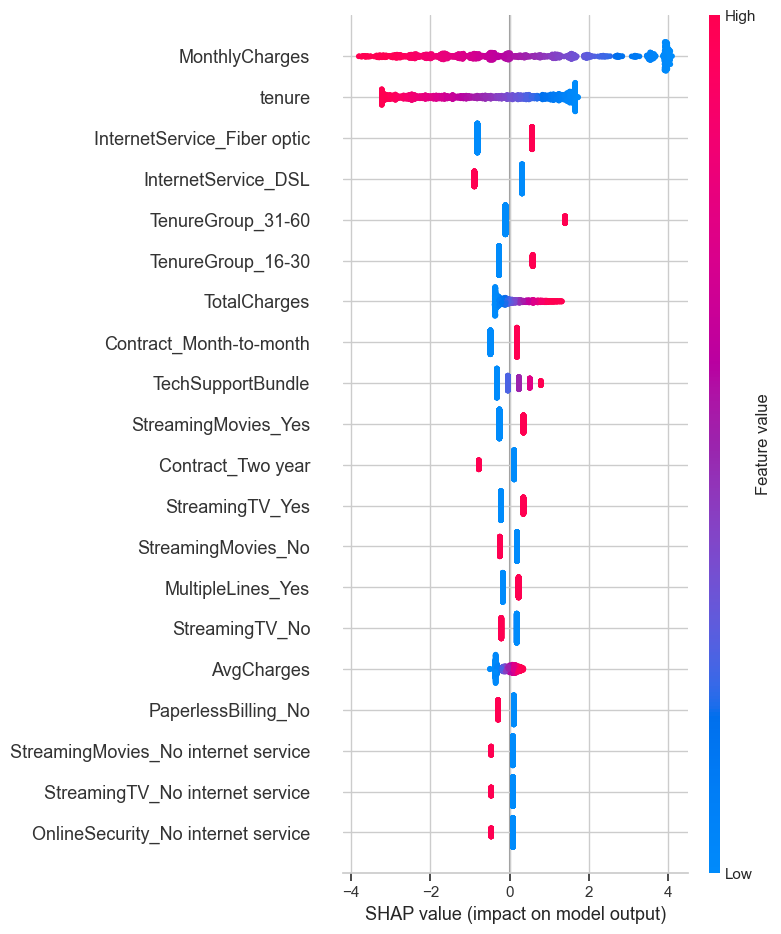

In [129]:
import shap

explainer = shap.LinearExplainer(lr_smote, X_train_smote, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=all_features)


**SHAP Summary Plot Key Insights:**

- **High Monthly Charges and Short Tenure** are the strongest drivers of churn, with customers paying more or new customers more likely to leave.  
- **Fiber Optic Internet and Month-to-Month Contracts** significantly increase churn risk due to potential service issues and low customer commitment.  
- **Lack of Support Services** (Tech Support, Online Security, Online Backup) raises churn probability, highlighting the importance of these add-ons.  
- **Streaming Services and Average Charges** also contribute moderately to churn, possibly due to increased costs or unmet expectations.  

These insights align well with telecom industry patterns and help target retention efforts effectively.


### **Model Saving**

In [130]:
import joblib

joblib.dump(best_l2, "final_churn_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(lr_smote, "lr_smote_model.pkl")

['lr_smote_model.pkl']

In [ ]:
#to use the model

import joblib
import pandas as pd

# Load preprocessor and model
preprocessor = joblib.load("preprocessor.pkl")
model = joblib.load("lr_smote_model.pkl")    # final tuned model

def predict_churn(input_data):
    """
    Takes a single customer record or dataframe as input 
    and returns churn probability + churn prediction.
    """
    # Convert dict → DataFrame if input is a dictionary
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])
    
    # Preprocess the input
    transformed = preprocessor.transform(input_data)
    
    # Predict churn probability and label
    prob = model.predict_proba(transformed)[0][1]
    pred = int(prob >= 0.63)   # Use your tuned threshold
    
    return {"churn_probability": prob, "churn_prediction": pred}


##  **Conclusion**

This notebook successfully built an end-to-end machine learning pipeline to predict customer churn using the IBM Telco dataset.  
After cleaning the data through EDA, we applied structured preprocessing, feature engineering, statistical validation, and multiple model evaluations to arrive at a practical, explainable, and business-ready churn prediction system.

### **Key Outcomes**
- Developed a complete preprocessing pipeline (encoding + scaling)
- Engineered impactful features such as **TenureGroup**, **AvgCharges**, and **TechSupportBundle**
- Validated EDA findings with **t-tests** and **chi-square tests**
- Trained and compared **7 machine learning models**
- Addressed class imbalance using **SMOTE**
- Tuned probability threshold to optimize the **recall and F1-score** for churners
- Achieved strong final performance:
  - **ROC-AUC:** ~0.84  
  - **Recall (Churn):** ~0.68  
  - **F1-score (Churn):** ~0.63  
- Used **SHAP** to interpret model behavior and confirm key churn drivers
- Saved the preprocessor and final model using **joblib**, and implemented a reusable `predict_churn()` function

### **Final Model Choice**
The best-performing model was:
**SMOTE + Threshold-Tuned Logistic Regression**

Chosen for its:
- Strong balance between recall and precision  
- High interpretability  
- Consistency and stability  
- Alignment with business needs  

###  **Business Takeaways**
The model and SHAP analysis highlight that churn is most strongly driven by:
- High monthly charges  
- Short tenure (0–60 days)  
- Fiber optic internet service  
- Month-to-month contracts  
- Lack of security/support services  

These insights support targeted retention strategies such as onboarding improvements, contract upgrade incentives, and service-quality enhancements.

Overall, this project demonstrates the full lifecycle of a predictive modeling workflow—from initial data understanding to final interpretability and deployment readiness.
